## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from variaIa import baserate
from variaIa import stretchevol
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

%matplotlib inline

## Définitions pandas, surveys, $z[:z_{\text{max}}]$, $x_1[:z_{\text{max}}]$, mean et std + cons

In [2]:
cons = ipw.Checkbox(
    value=False,
    description='Conservative')

In [3]:
d = pd.read_csv('../../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

surv = {'SNF':  d_snf.loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)],
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

dgmap = plt.cm.get_cmap('viridis')
colors = {'SNF': dgmap(0),
          'SDSS': dgmap(50),
          'PS1': dgmap(125),
          'SNLS': dgmap(200),
          'HST': dgmap(300)}

with open('../../Data/zmax_mlim', 'rb') as f:
    z_max = pickle.load(f)
z_max['HST'] = [10, 10]

zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()
x1_err_zcuts = dict()

z_zcuts['SNF'] = surv['SNF']['host.zcmb'].values
x1_zcuts['SNF'] = surv['SNF']['salt2.X1'].values
x1_err_zcuts['SNF'] = surv['SNF']['salt2.X1.err'].values

def set_cons(cons):
    global df
    
    names = []
    stretchs = []
    stretchs_err = []
    redshifts = []
    infor = list(surv['SNF']['p(prompt)'])
    py = list(surv['SNF']['p(prompt)'])
    lssfr = list(surv['SNF']['lssfr'])
    lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
    lssfr_err_u = list(surv['SNF']['lssfr.err_up'])
    
    if cons:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][0])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    else:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][-1])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    
    for survey in surveys:
        names += [survey for i in range(len(z_zcuts[survey]))]
        stretchs += list(x1_zcuts[survey])
        stretchs_err += list(x1_err_zcuts[survey])
        redshifts += list(z_zcuts[survey])
        if survey != 'SNF':
            infor += list(stretchevol.Evol2G2M2S().delta(z_zcuts[survey]))
            py += list([0 for i in range(len(z_zcuts[survey]))])
            lssfr += list([0 for i in range(len(z_zcuts[survey]))])
            lssfr_err_d += list([0 for i in range(len(z_zcuts[survey]))])
            lssfr_err_u += list([0 for i in range(len(z_zcuts[survey]))])

    df = pd.DataFrame({'survey': names,
                       'stretchs': stretchs,
                       'stretchs_err': stretchs_err,
                       'redshifts': redshifts,
                       'infor': infor,
                       'py': py,
                       'lssfr': lssfr,
                       'lssfr_err_d': lssfr_err_d,
                       'lssfr_err_u': lssfr_err_u})

    z_mean = np.mean(df.redshifts)
    z_std = np.std(df.redshifts)
    x1_mean = np.mean(df.stretchs)
    x1_std = np.std(df.stretchs)
    
    return(df)
            
int_set_cons = ipw.interactive(set_cons, cons=cons)
display(int_set_cons)

names = ['SNF' for i in range(len(z_zcuts['SNF']))]
stretchs = list(x1_zcuts['SNF'])
stretchs_err = list(x1_err_zcuts['SNF'])
redshifts = list(z_zcuts['SNF'])
infor = list(surv['SNF']['p(prompt)'])
py = list(surv['SNF']['p(prompt)'])
lssfr = list(surv['SNF']['lssfr'])
lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
lssfr_err_u = list(surv['SNF']['lssfr.err_up'])

for survey in surveys[1:]:
    names += [survey for i in range(len(surv[survey].zCMB.values))]
    stretchs += list(surv[survey].x1.values)
    stretchs_err += list(surv[survey].x1ERR.values)
    redshifts += list(surv[survey].zCMB.values)
    infor += list(stretchevol.Evol2G2M2S().delta(surv[survey].zCMB.values))
    py += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_d += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_u += list([0 for i in range(len(surv[survey].zCMB.values))])

df_full = pd.DataFrame({'survey': names,
                        'stretchs': stretchs,
                        'stretchs_err': stretchs_err,
                        'redshifts': redshifts,
                        'infor': infor,
                        'py': py,
                        'lssfr': lssfr,
                        'lssfr_err_d': lssfr_err_d,
                        'lssfr_err_u': lssfr_err_u})

df_nc = set_cons(False)
df_c = set_cons(True)

interactive(children=(Checkbox(value=False, description='Conservative'), Output()), _dom_classes=('widget-inte…

## Utilisation de la classe _stretchevol_ pour le fit double

In [4]:
evolSNF = stretchevol.Evol3G2M2S()
evolSNF.set_data(df[df['survey'] == 'SNF'])

evolSNF.minimize()

#fig=plt.gcf()
#fig.savefig('/home/nora/Documents/Thèse/Images/BiGaussian.pdf', bbox_inches='tight')

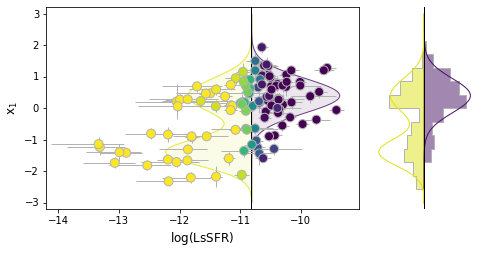

In [11]:
fig = plt.figure(figsize=[7, 3.5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
axh = fig.add_axes([0.75, 0.12, 0.2, 0.8])

evolSNF.scatter(ax=ax, mod_lw=1, elw=1, lw=1,
                     facealpha=1, show_leg=False)

prop = dict(orientation='horizontal',
            histtype='step',
            fill=True,
            range=(-3, 3), bins=14,
            lw=1)

axh.hist(evolSNF.stretchs, weights=evolSNF.py/12,
         facecolor=plt.cm.viridis(0.05, 0.5),
         edgecolor='0.7',
         **prop)
axh.hist(evolSNF.stretchs, weights=(evolSNF.py-1)/12,
         facecolor=plt.cm.viridis(0.95, 0.5),
         edgecolor="0.7",
#         edgecolor=plt.cm.viridis(0.95),
         **prop)

evolSNF.show_model_lssfr(ax=axh, facealpha=0,
                        edgealpha=1, lw=1, zorder=8)

ax.set_xlim(-14.2, -9.05)
ax.set_ylim(-3.2, 3.2)

axh.set_ylim(*ax.get_ylim())
axh.set_yticks([])
axh.set_xticks([])

axh.axvline(0, color='k', lw=1, zorder=10)

axh.set_frame_on(False)

path = '../../../../Images/model_base_hist.pdf'

fig.savefig(path, bbox_inches='tight')

## Fit results for _SNF_

In [8]:
path_r = '../../Data/SNF_results'

with open(path_r, 'wb') as f:
    pickle.dump(evolSNF.param, f)

## Définition loi analytique

In [5]:
def delta(z):
    return stretchevol.MockEvol().delta(z)

with open('../../Data/SNF_results', 'rb') as f:
    res_SNF = pickle.load(f)

def age_law_snf(z):
    """Analytical law with snf results"""
    return (delta(z)*res_SNF['mu_1'] +
        (1-delta(z))*(evolSNF.get_a(res_SNF['aa'])*res_SNF['mu_1']
                      + (1-evolSNF.get_a(res_SNF['aa']))*res_SNF['mu_2']))

def age_law_gen(z, param_hesse):
    """Function to get laws with parameters taken wrt there hesse error"""
    return (delta(z)*param_hesse[1]
      + (1-delta(z))*(evolSNF.get_a(param_hesse[0])*param_hesse[1]
                      + (1 - evolSNF.get_a(param_hesse[0]))*param_hesse[2]))

## Définition de _cov_ pour sélection aléatoire des paramètres

In [6]:
cov = im.Minuit.matrix(evolSNF.m_tot)
mean = [evolSNF.m_tot.values[i] for i in range(5)]
param_hesse_mat = scipy.stats.multivariate_normal.rvs(mean=mean, cov=cov, size=500)

### Only take _a_, _µ1_ and _µ2_

In [7]:
param_hesse_cut = param_hesse_mat[:,[0,1,3]]

### List of all the models

In [8]:
zlin = np.linspace(0, 2.65, 3000)
models_hesse = [[age_law_gen(zi, param_hesse) for zi in zlin] for param_hesse in param_hesse_cut]
models_hesse = np.asarray(models_hesse)

### Take _std_

In [9]:
models_std = np.std(models_hesse, axis=0)

## Tracé des $x_{\text{mean}}$ en fonction des $z_{\text{mean}}$ + analytic

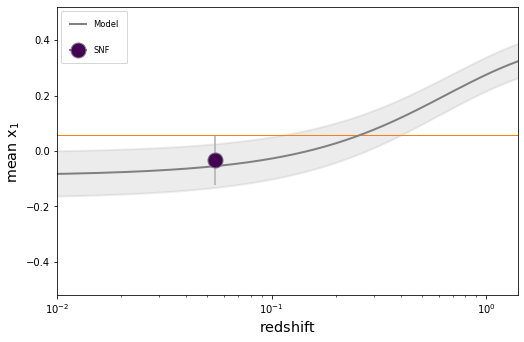

In [11]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

#prop = dict(marker="o", ms=10, ecolor="0.7", lw=2, mew=1, mec="0.5", zorder=5)
prop = dict(marker="o", ms=15, ecolor="0.7", mew=1, mec="0.5")

for survey in surveys[0:1]:
    ax.errorbar(np.mean(df_nc[df_nc['survey'] == survey].redshifts),
                np.mean(df_nc[df_nc['survey'] == survey].stretchs),
                xerr = np.std(df_nc[df_nc['survey'] == survey].redshifts)\
                /np.sqrt(len(df_nc[df_nc['survey'] == survey].redshifts)),
                yerr = np.std(df_nc[df_nc['survey'] == survey].stretchs)\
                /np.sqrt(len(df_nc[df_nc['survey'] == survey].stretchs)),
                color = colors[survey], label = survey, **prop)
    ax.errorbar(np.mean(df_c[df_c['survey'] == survey].redshifts),
                np.mean(df_c[df_c['survey'] == survey].stretchs),
                xerr = np.std(df_c[df_c['survey'] == survey].redshifts)\
                /np.sqrt(len(df_c[df_c['survey'] == survey].redshifts)),
                yerr = np.std(df_c[df_c['survey'] == survey].stretchs)\
                /np.sqrt(len(df_c[df_c['survey'] == survey].stretchs)),
                color = colors[survey], **prop,
                alpha=.3)

#ax.plot(zz, np.mean(x1_z, axis=1), color="0.7", zorder=2, label="BiGaussianModel")
ax.axhline(np.mean(df_nc.stretchs), lw=1, ls="-", color="C1")
#ax.axhline(np.mean(df_nc.stretchs), color='C1', lw=1, ls='-', label='Mean stretch')

zz = np.linspace(0,1.4,1000)

ax.plot(zz, age_law_snf(zz),
        color="0.5", lw=2, label='Model')

nb_mod = 10
ran_mod = np.random.choice(500, nb_mod)

#for i in range(nb_mod):
#    ax.plot(zz, models_hesse[ran_mod[i]], color="C1", lw=1)

ax.fill_between(zlin,
                age_law_snf(zlin) + models_std,
                age_law_snf(zlin) - models_std,
                color="0.3", alpha=.1, lw=2)

#ax.tick_params(labelsize=12)

ax.set_xlim(0.01, 1.4)
ax.set_xscale('log')
ax.set_ylim(-0.52, 0.52)

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{mean\,\,x}_1$ ", fontsize="x-large")

ax.legend(loc="upper left", ncol=1, fontsize="small",
          borderpad=1.05, labelspacing=2.)

fig.savefig('../../../../Images/stretchevol_model_snfonly.pdf', bbox_inches='tight')
fig.savefig('../../../../Images/stretchevol_model_snfonly.png', bbox_inches='tight', dpi=600)

## Calcul du $\chi²$

In [81]:
chi2_hline = 0
for i in range(5):
    chi2_hline += (list(x1_mean.values())[i] - np.mean(np.asarray(list(x1_mean.values()))))**2\
                    / (list(x1_std.values())[i]/np.sqrt(len(list(x1_zcuts.values())[i])))**2
    
chi2_model = 0
for i in range(5):
    chi2_model += (list(x1_mean.values())[i] - mock_law(np.asarray(list(z_mean.values())[i]),
                                                          m_mock.values['a'],
                                                          m_mock.values['b']))**2\
                    / (list(x1_std.values())[i]/np.sqrt(len(list(x1_zcuts.values())[i])))**2

delta_chi2 = chi2_hline - chi2_model

display(Latex("$\chi²_{\mathrm{hline}}$ = %5f " % chi2_hline))
display(Latex("$\chi²_{\mathrm{model}}$ = %5f " % chi2_model))
display(Latex("$\Delta\chi²$ = %5f " % delta_chi2))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>